In [1]:
class ConstantDict(object):
    """An enumeration class."""
    _dict = None

    @classmethod
    def dict(cls):
        """Dictionary of all upper-case constants."""
        if cls._dict is None:
            val = lambda x: getattr(cls, x)
            cls._dict = dict(((c, val(c)) for c in dir(cls) if c == c.upper()))
        return cls._dict
    
    def __contains__(self, value):
        return value in self.dict().values()

    def __iter__(self):
        for value in self.dict().values():
            yield value
            
class GitPlaceholder(ConstantDict):
    # Placeholders from https://git-scm.com/docs/pretty-formats
    SHA = "%H" # commit hash
    SHA_SHORT = "%h" # abbreviated commit hash
    TREE_HASH = "%T" # tree hash
    TREEHASH_SHORT = "%t" # abbreviated tree hash
    PARENT_HASHES = "%P" # parent hashes
    PARENT_HASHES_SHORT = "%p" # abbreviated parent hashes
    AUTHOR_NAME = "%an" # author name
    AUTHOR_NAME_MAILMAP = "%aN" # author name (respecting .mailmap, see git-shortlog(1) or git-blame(1))
    AUTHOR_EMAIL = "%ae" # author email
    AUTHOR_EMAIL_MAILMAP = "%aE" # author email (respecting .mailmap, see git-shortlog(1) or git-blame(1))
    AUTHOR_DATE = "%ad" # author date (format respects --date= option)
    AUTHOR_DATE_RFC2822 = "%aD" # author date, RFC2822 style
    AUTHOR_DATE_RELATIVE = "%ar" # author date, relative
    AUTHOR_DATE_UNIX = "%at" # author date, UNIX timestamp
    AUTHOR_DATE_ISO8601_LIKE = "%ai" # author date, ISO 8601-like format
    AUTHOR_DATE_ISO8601_STRICT = "%aI" # author date, strict ISO 8601 format
    COMMITTER_NAME = "%cn" # committer name
    COMMITTER_NAME_MAILMAP = "%cN" # committer name (respecting .mailmap, see git-shortlog(1) or git-blame(1))
    COMMITTER_EMAIL = "%ce" # committer email
    COMMITTER_EMAIL_MAILMAP = "%cE" # committer email (respecting .mailmap, see git-shortlog(1) or git-blame(1))
    COMMITTER_DATE = "%cd" # format respects --date= option)# committer date (format respects --date= option)
    COMMITTER_DATE_RFC2822 = "%cD" # committer date, RFC2822 style
    COMMITTER_DATE_RELATIVE = "%cr" # committer date, relative
    COMMITTER_DATE_UNIX = "%ct" # committer date, UNIX timestamp
    COMMITTER_DATE_ISO8601_LIKE = "%ci" # committer date, ISO 8601-like format
    COMMITTER_DATE_ISO8601_STRICT = "%cI" # committer date, strict ISO 8601 format
    REF_NAMES = "%d" # ref names, like the --decorate option of git-log(1)
    REF_NAMES_WITHOUT = "%D" # ref names without the "(", ")" wrapping.
    ENCODING = "%e" # encoding
    SUBJECT = "%s" # subject
    SUBJECT_LINE_SANITIZED = "%f" # sanitized subject line, suitable for a filename
    BODY = "%b" # body
    RAW_BODY = "%B" # raw body (unwrapped subject and body)
    COMMIT_NOTES = "%N" # commit notes
    
    _rev_dict = None
    @classmethod
    def name(cls, placeholder):
        GitPlaceholder.dict()
        if not cls._rev_dict:
            cls._rev_dict = dict((v,k) for k,v in cls._dict.items())
                
        name = cls._rev_dict.get(placeholder)
        if name:
            return name.lower()
        return name

In [2]:
import git 

GIT_LOG_FILE = r'C:\dev\repos\mojarra'
repo = git.Repo(GIT_LOG_FILE, odbt=git.GitCmdObjectDB)
g = repo.git
GIT_SEPARATOR = "\u0012"
info = [
    GitPlaceholder.SHA_SHORT, 
    GitPlaceholder.AUTHOR_DATE, 
    GitPlaceholder.AUTHOR_NAME, 
    GitPlaceholder.AUTHOR_EMAIL,
    GitPlaceholder.SUBJECT]

format_string =  GIT_SEPARATOR + GIT_SEPARATOR.join(info)
numstat = '--numstat'
log = g.log('--all', numstat, '--no-renames', '--pretty=format:"' + format_string + '"')
log[0:100]

'"\x129ff851923d\x12Tue Jul 4 13:20:10 2017 +0800\x12xinyuan-zhang\x12xinyuan.zhang@oracle.com\x12Merge pull request'

In [3]:
import pandas as pd
from io import StringIO

commits_raw = pd.read_csv(StringIO(log), 
    sep=GIT_SEPARATOR, 
    header=None,
    names=['data'])
commits_raw.head()                      

,data
0,9ff851923dTue Jul 4 13:20:10 2017 +0800xiny...
1,4b9790b036Tue Jul 4 13:19:37 2017 +0800xiny...
2,2426043e64Mon Jul 3 14:09:31 2017 +0800xiny...
3,5\t1\tjsf-tools/template-src/StateHolderSaver....
4,3918632c91Mon Jul 3 14:09:31 2017 +0800xiny...


In [1]:
commits_raw['data']

NameError: name 'commits_raw' is not defined

In [8]:
placeholdernames = [None] + [GitPlaceholder.name(x) for x in info]
placeholdernames

[None, 'sha_short', 'author_date', 'author_name', 'author_email', 'subject']

In [9]:
commit_metadata = commits_raw['data'].str.split(GIT_SEPARATOR, expand=True)
commit_metadata = commit_metadata.fillna(method='ffill')
commit_metadata.columns = placeholdernames
#commit_metadata['author_date'] = pd.to_datetime(commit_metadata['author_date'], infer_datetime_format=True)
commit_metadata.head()

,None,sha_short,author_date,author_name,author_email,subject
0,,9ff851923d,2017-07-04 05:20:10,xinyuan-zhang,xinyuan.zhang@oracle.com,Merge pull request #4256 from stiemannkj1/fix-...
1,,4b9790b036,2017-07-04 05:19:37,xinyuan-zhang,xinyuan.zhang@oracle.com,Merge pull request #4257 from stiemannkj1/fix-...
2,,2426043e64,2017-07-03 06:09:31,xinyuan-zhang,xinyuan.zhang@oracle.com,NullPointerException in StateHolderSaver contr...
3,5\t1\tjsf-tools/template-src/StateHolderSaver....,2426043e64,2017-07-03 06:09:31,xinyuan-zhang,xinyuan.zhang@oracle.com,NullPointerException in StateHolderSaver contr...
4,,3918632c91,2017-07-03 06:09:31,xinyuan-zhang,xinyuan.zhang@oracle.com,NullPointerException in StateHolderSaver contr...


In [41]:
file_info = commit_metadata[None].str.split("\t", expand=True).dropna()
file_info.columns = ['additions', "deletions", "filename"]
file_info.head()

,additions,deletions,filename
3,5,1,jsf-tools/template-src/StateHolderSaver.java
5,5,1,jsf-tools/template-src/StateHolderSaver.java
7,5,1,jsf-tools/template-src/StateHolderSaver.java
9,2,2,common/ant/common.xml
10,1,1,jsf-tools/pom.xml


In [42]:
file_info['additions'] = pd.to_numeric(file_info['additions'].replace("-", "0"))
file_info['deletions'] = pd.to_numeric(file_info['deletions'].replace("-", "0"))
file_info.dtypes

additions     int64
deletions     int64
filename     object
dtype: object

In [43]:
commits = commit_metadata.join(file_info, how='right')
del(commits[None])
commits.head()

,sha_short,author_date,author_name,author_email,subject,additions,deletions,filename
3,2426043e64,2017-07-03 06:09:31,xinyuan-zhang,xinyuan.zhang@oracle.com,NullPointerException in StateHolderSaver contr...,5,1,jsf-tools/template-src/StateHolderSaver.java
5,3918632c91,2017-07-03 06:09:31,xinyuan-zhang,xinyuan.zhang@oracle.com,NullPointerException in StateHolderSaver contr...,5,1,jsf-tools/template-src/StateHolderSaver.java
7,1b59dd81a1,2017-07-03 06:09:31,xinyuan-zhang,xinyuan.zhang@oracle.com,NullPointerException in StateHolderSaver contr...,5,1,jsf-tools/template-src/StateHolderSaver.java
9,455223088b,2017-06-28 05:07:41,xinyuan-zhang,xinyuan.zhang@oracle.com,Let's start work for release 2.3.3-SNAPSHOT,2,2,common/ant/common.xml
10,455223088b,2017-06-28 05:07:41,xinyuan-zhang,xinyuan.zhang@oracle.com,Let's start work for release 2.3.3-SNAPSHOT,1,1,jsf-tools/pom.xml


C:\dev\apps\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: 
.resample() is now a deferred operation
You called cumsum(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  from ipykernel import kernelapp as app


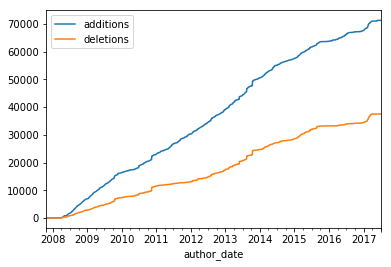

In [58]:
%matplotlib inline 
commits.set_index(commits['author_date']).resample('1D').cumsum().fillna(method='ffill').plot()